# Overnight Reversal

In [1]:
from datetime import datetime, date, time
from times import get_market_dates, get_market_calendar, first_trading_date_after, last_trading_date_before
from data import get_data
from tickers import get_tickers
from portfolio import Portfolio
import json
import pandas as pd
import warnings 

warnings.simplefilter(action='ignore', category=FutureWarning)

DATA_PATH = "../data/polygon/"
START_DATE = date(2003, 10, 1)
END_DATE = date(2024, 4, 1)
START_DATE = first_trading_date_after(START_DATE)
END_DATE = last_trading_date_before(END_DATE)

### Backtest loop
Long at close if:
* Intraday 20% drop
* More than $5M volume
* Above $1
* Avoid trading on listing or delisting date

Position sizing:
* 20% (max. 5)
* If more than 5, rank on largest intraday drop

In [2]:
# Initialize historical scanner, portfolio and calendar
with open("../output/screens/INTRADAY_MINUS_20PCT.json", "r") as f:
    D20 = json.load(f)

data = {}
portfolio = Portfolio(START_DATE, data, initial_capital=10000)
calendar = get_market_calendar("datetime")

# LOOP THROUGH ALL DAYS
for day in get_market_dates(START_DATE, END_DATE):
    market_open_dt = calendar.loc[day, "regular_open"]
    market_close_dt = calendar.loc[day, "regular_close"]
    next_day_open_dt = calendar.loc[first_trading_date_after(day), "regular_open"]
    
    # AT MARKET OPEN
    # Close all positions
    for ticker, quantity in portfolio.current_positions.items():
        if quantity != 0:
            exit_price = data[ticker].loc[market_open_dt, "open"]
            action = "SELL" if quantity > 0 else "BUY"
            portfolio.update_from_fill(
                dt=market_open_dt,
                side=action,
                symbol=ticker,
                fill_quantity=abs(quantity),
                fill_price=exit_price,
                fees=exit_price*0.003*abs(quantity),
            )
    # Reset data
    data.clear()

    # AT MARKET CLOSE
    # Scan for gappers
    intraday_droppers = D20[day.isoformat()]

    # Go to next day if nothing on the scans
    if not intraday_droppers:
        continue
    
    # Load data
    for ticker in intraday_droppers:
        data[ticker] = get_data(ticker_or_id=ticker, 
                            start_date=market_open_dt, 
                            end_date=next_day_open_dt, 
                            timeframe=1,
                            columns=['open', 'close', 'close_original'])

    # Calculate drop
    qualified_droppers = {}
    for ticker in intraday_droppers:
        # Avoid trading on first day of listing and the day of delisting
        try:
            data[ticker].loc[market_open_dt]
            data[ticker].loc[next_day_open_dt]
        except:
            continue

        current_open = data[ticker].loc[market_open_dt, "open"]
        current_close = data[ticker].loc[market_close_dt, "close"]
        qualified_droppers[ticker] = (1-current_close/current_open)*100 # Base 100
        
    if not qualified_droppers:
        continue

    # Get the top gappers
    sorted_drops = dict(sorted(qualified_droppers.items(), key=lambda x: x[1], reverse=True))
    
    # Market order with 20% of cash
    size = portfolio.current_cash * 0.2
    amount_day_trades = 0
    for ticker in sorted_drops.keys():
        current_close = data[ticker].loc[market_close_dt, "close"]
        quantity = int(size / current_close)
        portfolio.update_from_fill(
            dt=market_close_dt,
            side="BUY",
            symbol=ticker,
            fill_quantity=quantity,
            fill_price=current_close,
            fees=current_close*0.003*abs(quantity),
        )
        amount_day_trades += 1
        if amount_day_trades == 5:
            break
          
    portfolio.append_portfolio_log(market_close_dt)

### Results

In [3]:
from performance import fills_to_trades
portfolio_log = portfolio.get_df_from_holdings_log()
fills_log = portfolio.get_df_from_fills_log()
trade_log = fills_to_trades(fills_log)
trade_log = trade_log.drop(columns=['remaining_qty', 'net P/L $'])

trade_log.to_csv('../output/trade_log_overnight_reversal.csv')

In [4]:
trade_log.head(3)

,datetime_in,symbol,side,quantity,entry,exit,datetime_out,fees,net P/L %
0,2003-10-03 15:59:00,CKC-2003-09-10,BUY,819,2.4400,2.4000,2003-10-06 09:30:00,11.90,-2.23
1,2003-10-06 15:59:00,WTU-2003-09-10,BUY,342,5.8061,5.9532,2003-10-07 09:30:00,12.07,1.93
2,2003-10-13 15:59:00,COB-2003-09-10,BUY,233,8.5600,8.5400,2003-10-14 09:30:00,11.95,-0.83


In [5]:
portfolio_log.head(3)

,equity,cash,positions_value,positions,return,return_cum
datetime,,,,,,
2003-10-02,10000.000,10000.000,0.000,{},0.000,0.000
2003-10-03 15:59:00,9994.005,7995.645,1998.360,{'CKC-2003-09-10': 819},-0.060,-0.060
2003-10-06 15:59:00,9949.391,7963.705,1985.686,{'WTU-2003-09-10': 342},-0.446,-0.506


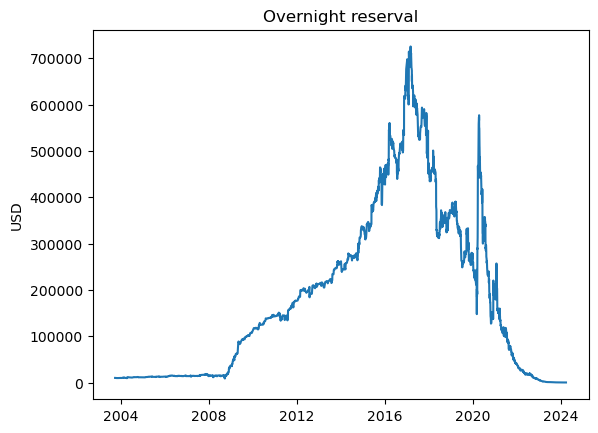

In [6]:
from matplotlib import pyplot as plt
plt.plot(portfolio_log.index, portfolio_log.equity)
plt.title('Overnight reserval')
plt.ylabel('USD')
plt.show()